In [25]:
from __future__ import print_function

import pandas as pd
import numpy as np
from datetime import datetime

import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline

from collections import defaultdict
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
from pgmpy.inference import VariableElimination

from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.over_sampling import SMOTE

## Data preprocessing

In [97]:
dbn = pd.read_csv('data/dbn_for_models.csv')
dbn.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,0,0,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
dbn.dtypes

defects_exist                 int64
years_since_last_defects      int64
bldgarea                    float64
unitstotal                  float64
builtfar                    float64
median_household_income     float64
over_65_pct                 float64
over_white_pct              float64
dummy_pressure_type           int64
dummy_make                     bool
dummy_model                    bool
dummy_tract                    bool
dummy_owner                    bool
defects_history               int64
landuse_1.0                 float64
landuse_2.0                 float64
landuse_3.0                 float64
landuse_4.0                 float64
landuse_5.0                 float64
landuse_6.0                 float64
landuse_7.0                 float64
landuse_8.0                 float64
landuse_9.0                 float64
landuse_10.0                float64
landuse_11.0                float64
dtype: object

### Numeric columns to categorical

In [99]:
numeric_cols = list(dbn.columns[1:8]) + ['defects_history']
dbn.loc[:,numeric_cols].head()

,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,defects_history
0,0,185785.0,8.0,10.38,135588.0,0.14173,0.783066,0
1,1,185785.0,8.0,10.38,135588.0,0.14173,0.783066,0
2,2,185785.0,8.0,10.38,135588.0,0.14173,0.783066,0
3,3,185785.0,8.0,10.38,135588.0,0.14173,0.783066,0
4,4,185785.0,8.0,10.38,135588.0,0.14173,0.783066,0


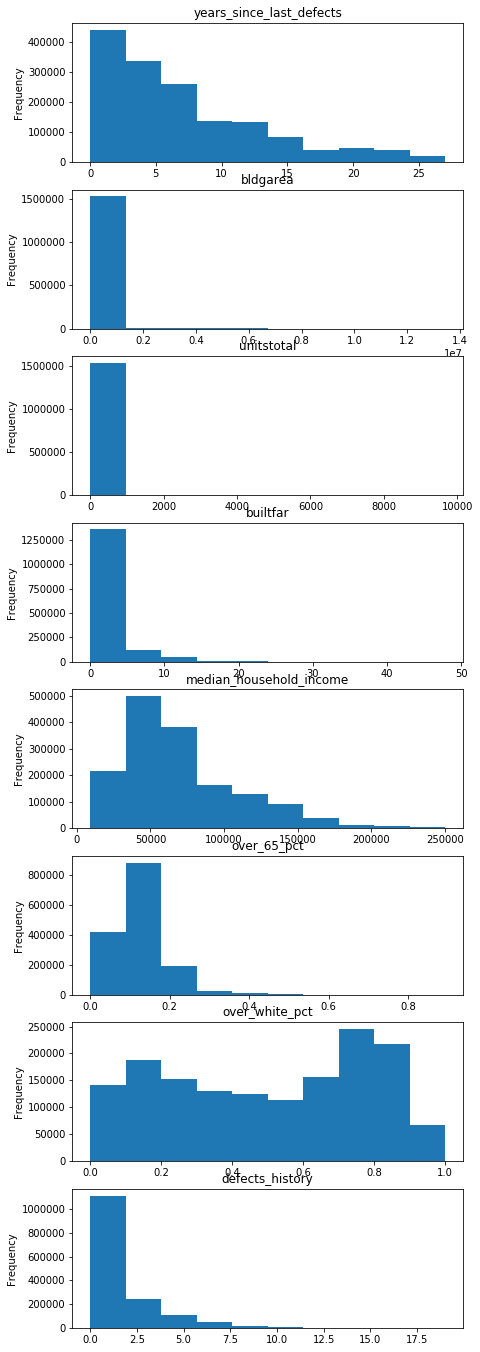

In [6]:
fig, axes = plt.subplots(nrows=len(numeric_cols), figsize=(7, 3*len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    dbn[col].plot.hist(ax=ax)
    ax.set_title(col)

Based on the distributions above, I did the cut differently for highly skewed variables: dividing into more bins and then grouping all the top bins in one. All variables end with 5 bins.

In [100]:
fix_cut = ['builtfar','over_65_pct','defects_history']
extreme_outliers = ['bldgarea','unitstotal']

for col in numeric_cols:
    if col in fix_cut:
        dbn[col] = pd.cut(dbn[col], 10, labels=False)
        dbn[col] = dbn[col].apply(lambda x: 4 if x > 4 else x)
    elif col in extreme_outliers:
        dbn[col] = pd.cut(dbn[col], 30, labels=False)
        dbn[col] = dbn[col].apply(lambda x: 4 if x > 4 else x)
    else:
        dbn[col] = pd.cut(dbn[col], 5, labels=False)
dbn.iloc[:,1:8].head()

,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct
0,0,0,0,2,2,1,3
1,0,0,0,2,2,1,3
2,0,0,0,2,2,1,3
3,0,0,0,2,2,1,3
4,0,0,0,2,2,1,3


In [101]:
showdists = pd.DataFrame()

for col in numeric_cols:
    showdists[col] = dbn[col].value_counts()
    
showdists

,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,defects_history
0,778193,1511401,1508314,1359331,714227,420060,329511,1116157
1,394421,18625,15976,119163,544877,886121,282190,242806
2,216420,3511,6215,43449,219378,193672,239062,109335
3,86426,1640,3178,8837,47107,22338,400650,45400
4,60534,817,2311,5214,10405,13803,284581,22296


## Train/Test split

In [106]:
X, y = dbn.iloc[:,1:], dbn.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 2015)

In [107]:
train = pd.DataFrame(data=np.concatenate((y_train[:,None],X_train), axis=1), columns=dbn.columns).astype(int)
train.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,1,0,0,0,0,0,0,3,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,2,3,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,2,0,0,0,2,1,4,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,3,1,0,...,0,0,0,0,0,0,1,0,0,0


In [108]:
test = pd.DataFrame(data=np.concatenate((y_test[:,None],X_test), axis=1), columns=dbn.columns).astype(int)
test.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,0,1,0,0,0,0,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
1,0,2,0,0,1,1,1,3,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,1,2,4,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,3,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0


## Bayesian Network Modeling

In [138]:
def temp_predict(model, data):
    missing_variables = list(set(model.nodes()) - set(data.columns))
    pred_values = defaultdict(list)
    model_inference = VariableElimination(model)
    for index, data_point in data.iterrows():
        states_dict = model_inference.map_query(variables=missing_variables, evidence=data_point.astype(int).to_dict())
        for k, v in states_dict.items():
            pred_values[k].append(v)
    return pd.DataFrame(pred_values, index=data.index)

def print_pred_stats(y_test, y_test_pred, prob_threshold=0.5):
    
    y_test_pred_class = (y_test_pred > prob_threshold)
    
    print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(y_test, y_test_pred_class)))
    print('Recall: {:.2f}%'.format(metrics.recall_score(y_test, y_test_pred_class)*100))
    print('Precision: {:.2f}%'.format(metrics.precision_score(y_test, y_test_pred_class)*100))
    print('F1 score: {:.2f}%'.format(metrics.f1_score(y_test, y_test_pred_class)*100))
    print('Accuracy (OS): {:.2f}%\n'.format(metrics.accuracy_score(y_test, y_test_pred_class)*100))
    print(metrics.classification_report(y_test, y_test_pred_class, labels=[0,1]))

def train_bn(train):
    start = datetime.now()
    print("Train start time: {}\n".format(start))
    
    #Learn Network structure from train data
    hc = HillClimbSearch(train, scoring_method=BicScore(train))
    best_model = hc.estimate()
    print("Network edges: \n{}\n".format(best_model.edges()))
    
    #Learn conditional probabilities from train data
    best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
    print("Local independencies: \n{}\n".format(best_model.local_independencies(best_model.nodes())))
    
    end = datetime.now()
    print('Train end time: {}'.format(end))
    print('Train took {:.2f} minutes\n'.format((end-start).total_seconds()/60))
    
    return best_model

def predict_bn(model, test, pred_variable, test_sample_size=0.05, use_temp_predict=False, prob_treshold=0.5):
    start = datetime.now()
    print("Predict start time: {}\n".format(start))
    
    #Predict on test sample
    test_sample = test.sample(frac=test_sample_size)
    
    x_test_sample = test_sample.loc[:,test_sample.columns.drop(pred_variable)]
    y_test_sample = test_sample.loc[:,pred_variable]
    
    if use_temp_predict:
        y_test_sample_pred = temp_predict(best_model, x_test_sample)[pred_variable]
    else:
        y_test_sample_pred = model.predict_probability(x_test_sample)[pred_variable + '_1'] # should work, but is buggy in the current version (?)
        
    end = datetime.now()
    
    print('Predict end time: {}'.format(end))
    print('Predict took {:.2f} minutes\n'.format((end-start).total_seconds()/60))
    
    print_pred_stats(y_test_sample, y_test_sample_pred, prob_threshold=0.5)
    
    return y_test_sample, y_test_sample_pred

def plot_tresholds(y_test, y_test_pred):
    
    res = pd.DataFrame()
    
    for t in np.linspace(0,0.5,11):
        y_test_pred_class = (y_test_pred > t)
        
        data = {
            'Threshold':t,
            'Recall': metrics.recall_score(y_test, y_test_pred_class)*100,
            'Precision': metrics.precision_score(y_test, y_test_pred_class)*100,
            'F1 score': metrics.f1_score(y_test, y_test_pred_class)*100,
            'Accuracy (OS)': metrics.accuracy_score(y_test, y_test_pred_class)*100
        }
        
        res = res.append(data, ignore_index=True)
        
    res.set_index('Threshold', inplace=True)
        
    res.plot()
          
    return res

### BN v1: Use building + bioler features (not categorical/dummies)

In [127]:
use_cols = ['defects_exist',
 'years_since_last_defects',
 'bldgarea',
 'unitstotal',
 'builtfar',
 'defects_history']

bn_1 = train_bn(train[use_cols])
y_test_sample_bn1, y_test_sample_pred_bn1 = predict_bn(bn_1, test[use_cols], 'defects_exist')

Train start time: 2019-05-09 15:37:54.025602

Network edges: 
[('defects_exist', 'defects_history'), ('defects_exist', 'builtfar'), ('defects_exist', 'years_since_last_defects'), ('bldgarea', 'unitstotal'), ('unitstotal', 'defects_exist')]

Local independencies: 
(builtfar _|_ defects_history, bldgarea, years_since_last_defects, unitstotal | defects_exist)
(defects_exist _|_ bldgarea | unitstotal)
(years_since_last_defects _|_ defects_history, bldgarea, builtfar, unitstotal | defects_exist)
(defects_history _|_ builtfar, bldgarea, years_since_last_defects, unitstotal | defects_exist)

Train end time: 2019-05-09 15:39:58.463224
Train took 2.07 minutes

Predict start time: 2019-05-09 15:39:58.473356

Predict end time: 2019-05-09 15:43:35.399112
Predict took 3.62 minutes

Confusion matrix:
[[27199     0]
 [ 3521     0]]

Recall: 0.00%
Precision: 0.00%
F1 score: 0.00%
Accuracy (OS): 88.54%

              precision    recall  f1-score   support

           0       0.89      1.00      0.94  

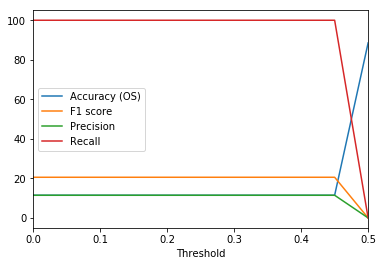

In [140]:
res_bn1 = plot_tresholds(y_test_sample_bn1, y_test_sample_pred_bn1)

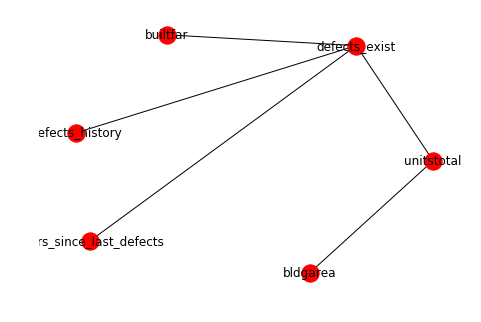

In [55]:
nx.draw(bn_1.to_undirected(), with_labels=True)
plt.show()

### BN v2: Use only one measure of building density + median household income

Train start time: 2019-05-09 15:51:34.424723

Network edges: 
[('bldgarea', 'defects_exist'), ('defects_exist', 'defects_history'), ('defects_exist', 'years_since_last_defects'), ('defects_exist', 'median_household_income')]

Local independencies: 
(defects_history _|_ bldgarea, years_since_last_defects, median_household_income | defects_exist)
(years_since_last_defects _|_ defects_history, bldgarea, median_household_income | defects_exist)
(median_household_income _|_ defects_history, bldgarea, years_since_last_defects | defects_exist)

Train end time: 2019-05-09 15:52:02.807399
Train took 0.47 minutes

Predict start time: 2019-05-09 15:52:02.814146

Predict end time: 2019-05-09 15:54:55.555434
Predict took 2.88 minutes

Confusion matrix:
[[27191     0]
 [ 3529     0]]

Recall: 0.00%
Precision: 0.00%
F1 score: 0.00%
Accuracy (OS): 88.51%

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27191
           1       0.00      0.00      

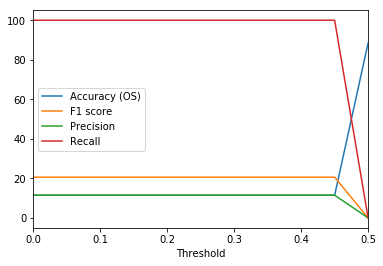

In [142]:
use_cols = ['defects_exist',
            'years_since_last_defects',
            'bldgarea',
            'median_household_income',
            'defects_history']

bn_2 = train_bn(train[use_cols])
y_test_sample_bn2, y_test_sample_pred_bn2 = predict_bn(bn_2, test[use_cols], 'defects_exist')
res_bn2 = plot_tresholds(y_test_sample_bn2, y_test_sample_pred_bn2)

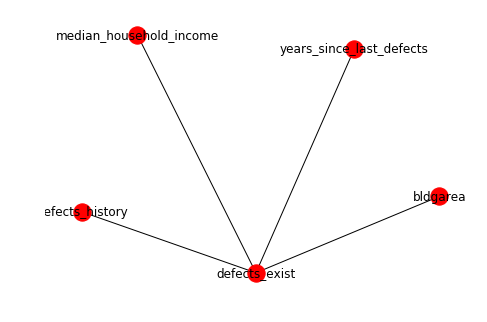

In [54]:
nx.draw(bn_2.to_undirected(), with_labels=True)
plt.show()

## Using balanced train set with SMOTE

In [143]:
sampler = SMOTE(random_state=1992)
X_train_smote, y_train_smote = sampler.fit_resample(X_train, y_train)

In [144]:
train_smote = pd.DataFrame(data=np.concatenate((y_train_smote[:,None],X_train_smote), axis=1), columns=dbn.columns).astype(int)
train_smote.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,1,0,0,0,0,0,0,3,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,2,3,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,2,0,0,0,2,1,4,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,3,1,0,...,0,0,0,0,0,0,1,0,0,0


In [145]:
train_smote.shape

(1629554, 25)

### BN SMOTE v1

Train start time: 2019-05-09 15:57:40.930043

Network edges: 
[('defects_exist', 'defects_history'), ('defects_exist', 'builtfar'), ('defects_exist', 'years_since_last_defects'), ('bldgarea', 'unitstotal'), ('unitstotal', 'defects_exist')]

Local independencies: 
(builtfar _|_ defects_history, bldgarea, years_since_last_defects, unitstotal | defects_exist)
(defects_exist _|_ bldgarea | unitstotal)
(years_since_last_defects _|_ defects_history, bldgarea, builtfar, unitstotal | defects_exist)
(defects_history _|_ builtfar, bldgarea, years_since_last_defects, unitstotal | defects_exist)

Train end time: 2019-05-09 15:59:31.996907
Train took 1.85 minutes

Predict start time: 2019-05-09 15:59:32.005442

Predict end time: 2019-05-09 16:03:13.739410
Predict took 3.70 minutes

Confusion matrix:
[[27153     0]
 [ 3567     0]]

Recall: 0.00%
Precision: 0.00%
F1 score: 0.00%
Accuracy (OS): 88.39%

              precision    recall  f1-score   support

           0       0.88      1.00      0.94  

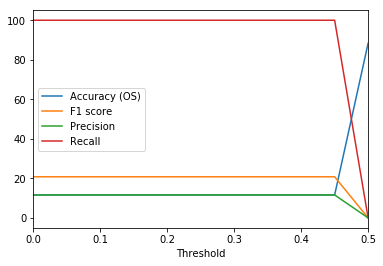

In [146]:
use_cols = ['defects_exist',
            'years_since_last_defects',
            'bldgarea',
            'unitstotal',
            'builtfar',
            'defects_history']

bn_smote_1 = train_bn(train_smote[use_cols])
y_test_sample_bn_smote_1, y_test_sample_pred_bn_smote_1 = predict_bn(bn_smote_1, test[use_cols], 'defects_exist')
res_bn_smote_1 = plot_tresholds(y_test_sample_bn_smote_1, y_test_sample_pred_bn_smote_1)

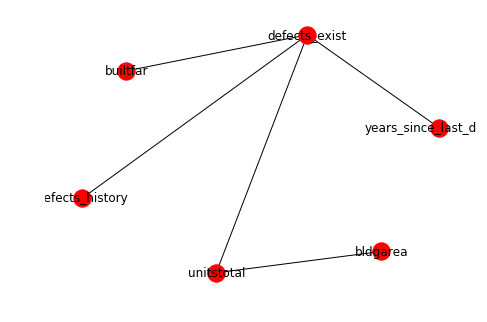

In [46]:
nx.draw(bn_smote_1.to_undirected(), with_labels=True)
plt.show()

### BN SMOTE v2

Train start time: 2019-05-09 16:03:14.342132

Network edges: 
[('bldgarea', 'defects_exist'), ('defects_exist', 'defects_history'), ('defects_exist', 'years_since_last_defects'), ('defects_exist', 'median_household_income')]

Local independencies: 
(defects_history _|_ bldgarea, years_since_last_defects, median_household_income | defects_exist)
(years_since_last_defects _|_ defects_history, bldgarea, median_household_income | defects_exist)
(median_household_income _|_ defects_history, bldgarea, years_since_last_defects | defects_exist)

Train end time: 2019-05-09 16:05:23.782510
Train took 2.16 minutes

Predict start time: 2019-05-09 16:05:23.789205

Predict end time: 2019-05-09 16:08:17.261403
Predict took 2.89 minutes

Confusion matrix:
[[27145     0]
 [ 3575     0]]

Recall: 0.00%
Precision: 0.00%
F1 score: 0.00%
Accuracy (OS): 88.36%

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     27145
           1       0.00      0.00      

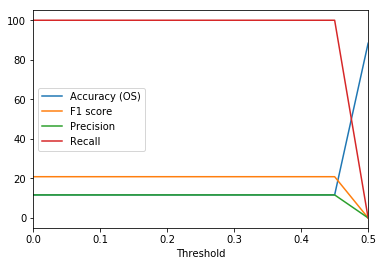

In [147]:
use_cols = ['defects_exist',
            'years_since_last_defects',
            'bldgarea',
            'median_household_income',
            'defects_history']

bn_smote_2 = train_bn(train_smote[use_cols])
y_test_sample_bn_smote_2, y_test_sample_pred_bn_smote_2 = predict_bn(bn_smote_2, test[use_cols], 'defects_exist')
res_bn_smote_2 = plot_tresholds(y_test_sample_bn_smote_2, y_test_sample_pred_bn_smote_2)

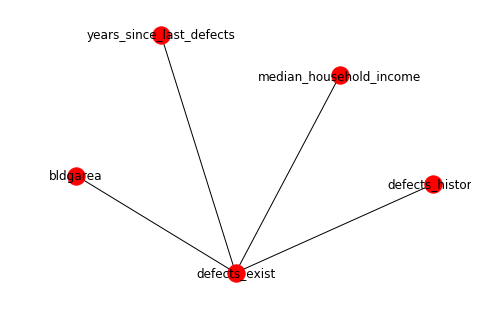

In [47]:
nx.draw(bn_smote_2.to_undirected(), with_labels=True)
plt.show()

### BN SMOTE v3 - most important features from RFC

In [ ]:
use_cols = ['defects_exist',
            'years_since_last_defects',
            'bldgarea',
            'unitstotal',
            'builtfar',
            'median_household_income']

bn_smote_3 = train_bn(train_smote[use_cols])
y_test_sample_bn_smote_3, y_test_sample_pred_bn_smote_3 = predict_bn(bn_smote_3, test[use_cols], 'defects_exist')
res_bn_smote_3 = plot_tresholds(y_test_sample_bn_smote_3, y_test_sample_pred_bn_smote_3)

Train start time: 2019-05-09 16:08:17.771051



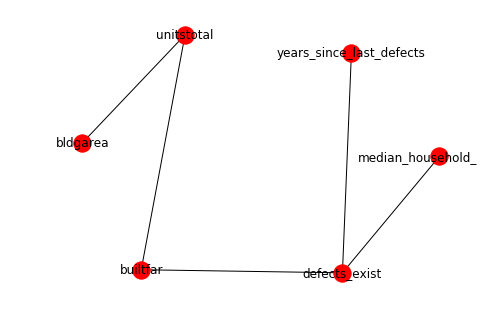

In [51]:
nx.draw(bn_smote_3.to_undirected(), with_labels=True)
plt.show()

### BN v4 - all numeric variables

Network edges: 
[('builtfar', 'defects_exist'), ('defects_exist', 'defects_history'), ('defects_exist', 'years_since_last_defects'), ('defects_exist', 'median_household_income'), ('defects_exist', 'over_white_pct'), ('defects_exist', 'over_65_pct'), ('bldgarea', 'unitstotal'), ('unitstotal', 'builtfar')]

Local independencies: 
(builtfar _|_ bldgarea | unitstotal)
(defects_exist _|_ bldgarea, unitstotal | builtfar)
(over_white_pct _|_ builtfar, median_household_income, defects_history, years_since_last_defects, bldgarea, unitstotal, over_65_pct | defects_exist)
(years_since_last_defects _|_ builtfar, median_household_income, defects_history, bldgarea, unitstotal, over_white_pct, over_65_pct | defects_exist)
(over_65_pct _|_ builtfar, median_household_income, defects_history, years_since_last_defects, bldgarea, over_white_pct, unitstotal | defects_exist)
(defects_history _|_ builtfar, median_household_income, years_since_last_defects, bldgarea, unitstotal, over_white_pct, over_65_pct | 

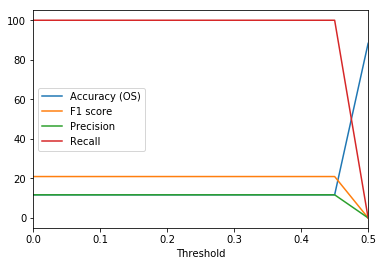

In [149]:
use_cols = ['defects_exist',
            'years_since_last_defects',
            'bldgarea',
            'unitstotal',
            'builtfar',
            'median_household_income',
            'over_65_pct',
            'over_white_pct',
            'defects_history']

bn_smote_4 = train_bn(train_smote[use_cols])
y_test_sample_bn_smote_4, y_test_sample_pred_bn_smote_4 = predict_bn(bn_smote_4, test[use_cols], 'defects_exist')
res_bn_smote_4 = plot_tresholds(y_test_sample_bn_smote_4, y_test_sample_pred_bn_smote_4)

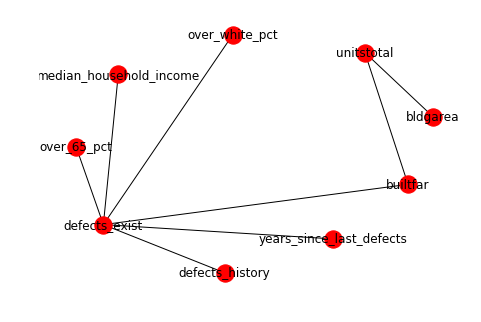

In [53]:
nx.draw(bn_smote_4.to_undirected(), with_labels=True)
plt.show()

## Try raw variables, excluding demographics

In [ ]:
dbn2 = pd.read_csv('data/dbn_for_models.csv')
dbn2.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,0,0,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X, y = dbn2.iloc[:,1:], dbn2.iloc[:,0]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.4, random_state = 2015)

In [ ]:
train2 = pd.DataFrame(data=np.concatenate((y_train2[:,None],X_train2), axis=1), columns=dbn2.columns).astype(int)
train2.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,1,2,43114,3,1,40272,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,5,43998,1,4,71899,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,13,56023,60,4,114408,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,1,9659,10,3,70651,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
4,0,2,4461,0,0,72302,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
test2 = pd.DataFrame(data=np.concatenate((y_test2[:,None],X_test2), axis=1), columns=dbn2.columns).astype(int)
test2.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,0,10,2400,8,0,52438,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,0,12,23148,24,9,93078,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1,3,72150,60,2,66194,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,5,2800,2,1,74688,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,3600,6,2,32083,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


### Only boiler inspection data

Train start time: 2019-05-09 16:40:30.107743

Network edges: 
[('defects_exist', 'defects_history'), ('defects_exist', 'years_since_last_defects')]

Local independencies: 
(defects_history _|_ years_since_last_defects | defects_exist)
(years_since_last_defects _|_ defects_history | defects_exist)

Train end time: 2019-05-09 16:40:41.659369
Train took 0.19 minutes

Predict start time: 2019-05-09 16:40:41.685646

Predict end time: 2019-05-09 16:43:32.358311
Predict took 2.84 minutes

Confusion matrix:
[[27238     0]
 [ 3482     0]]

Recall: 0.00%
Precision: 0.00%
F1 score: 0.00%
Accuracy (OS): 88.67%

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27238
           1       0.00      0.00      0.00      3482

   micro avg       0.89      0.89      0.89     30720
   macro avg       0.44      0.50      0.47     30720
weighted avg       0.79      0.89      0.83     30720



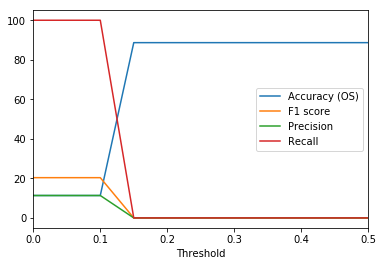

In [ ]:
use_cols = ['defects_exist',
 'years_since_last_defects',
 'defects_history']

bn_raw_1 = train_bn(train2[use_cols])
y_test_sample_bn_raw_1, y_test_sample_pred_bn_raw_1 = predict_bn(bn_raw_1, test2[use_cols], 'defects_exist')
res_bn_raw_1 = plot_tresholds(y_test_sample_bn_raw_1, y_test_sample_pred_bn_raw_1)

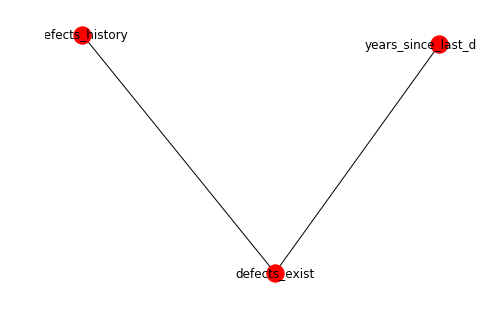

In [72]:
nx.draw(bn_raw_1.to_undirected(), with_labels=True)
plt.show()

### With SMOTE

In [ ]:
sampler = SMOTE(random_state=1992)
X_train_smote2, y_train_smote2 = sampler.fit_resample(X_train2, y_train2)

In [ ]:
train_smote2 = pd.DataFrame(data=np.concatenate((y_train_smote2[:,None],X_train_smote2), axis=1), columns=dbn2.columns).astype(int)
train_smote2.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,1,2,43114,3,1,40272,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,5,43998,1,4,71899,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,13,56023,60,4,114408,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,1,9659,10,3,70651,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
4,0,2,4461,0,0,72302,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Train start time: 2019-05-09 16:43:53.007531

Network edges: 
[('defects_exist', 'defects_history'), ('defects_exist', 'years_since_last_defects')]

Local independencies: 
(defects_history _|_ years_since_last_defects | defects_exist)
(years_since_last_defects _|_ defects_history | defects_exist)

Train end time: 2019-05-09 16:44:02.155273
Train took 0.15 minutes

Predict start time: 2019-05-09 16:44:02.159945

Predict end time: 2019-05-09 16:47:02.676509
Predict took 3.01 minutes

Confusion matrix:
[[27118     0]
 [ 3602     0]]

Recall: 0.00%
Precision: 0.00%
F1 score: 0.00%
Accuracy (OS): 88.27%

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     27118
           1       0.00      0.00      0.00      3602

   micro avg       0.88      0.88      0.88     30720
   macro avg       0.44      0.50      0.47     30720
weighted avg       0.78      0.88      0.83     30720



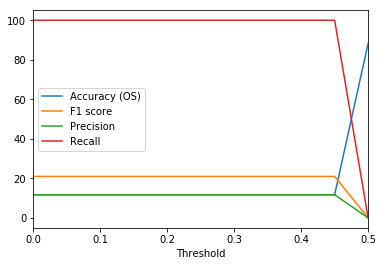

In [ ]:
use_cols = ['defects_exist',
 'years_since_last_defects',
 'defects_history']

bn_raw_smote_1 = train_bn(train_smote2[use_cols])
y_test_sample_bn_raw_smote_1, y_test_sample_pred_bn_raw_smote_1 = predict_bn(bn_raw_smote_1, test2[use_cols], 'defects_exist')
res_bn_raw_smote_1 = plot_tresholds(y_test_sample_bn_raw_smote_1, y_test_sample_pred_bn_raw_smote_1)

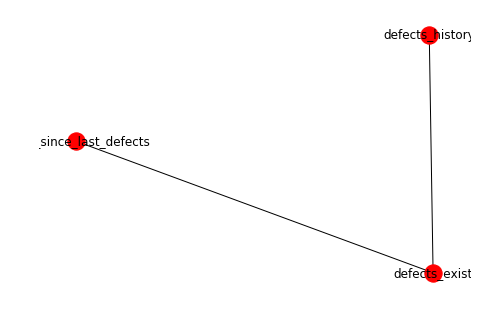

In [76]:
nx.draw(bn_raw_smote_1.to_undirected(), with_labels=True)
plt.show()

### Adding dummies

Train start time: 2019-05-09 16:47:03.314114

Network edges: 
[('dummy_make', 'dummy_model'), ('defects_exist', 'defects_history'), ('defects_exist', 'dummy_owner'), ('dummy_model', 'years_since_last_defects'), ('dummy_model', 'defects_exist'), ('dummy_tract', 'dummy_make')]

Local independencies: 
(defects_exist _|_ dummy_make, years_since_last_defects, dummy_tract | dummy_model)
(dummy_model _|_ dummy_tract | dummy_make)
(years_since_last_defects _|_ defects_history, dummy_owner, dummy_make, dummy_tract, defects_exist | dummy_model)
(defects_history _|_ dummy_model, dummy_make, dummy_tract, dummy_owner, years_since_last_defects | defects_exist)
(dummy_owner _|_ defects_history, dummy_model, dummy_make, dummy_tract, years_since_last_defects | defects_exist)

Train end time: 2019-05-09 16:53:47.122898
Train took 6.73 minutes

Predict start time: 2019-05-09 16:53:47.132234

Predict end time: 2019-05-09 16:58:49.577010
Predict took 5.04 minutes

Confusion matrix:
[[27228     0]
 [ 3492  

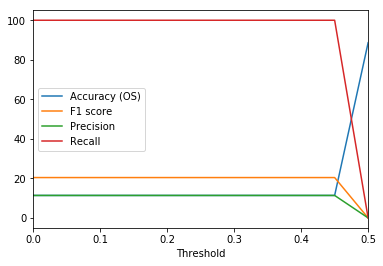

In [ ]:
use_cols = ['defects_exist', 'years_since_last_defects', 'dummy_make',
       'dummy_model', 'dummy_tract', 'dummy_owner', 'defects_history']

bn_raw_smote_2 = train_bn(train_smote2[use_cols])
y_test_sample_bn_raw_smote_2, y_test_sample_pred_bn_raw_smote_2 = predict_bn(bn_raw_smote_2, test2[use_cols], 'defects_exist')
res_bn_raw_smote_2 = plot_tresholds(y_test_sample_bn_raw_smote_2, y_test_sample_pred_bn_raw_smote_2)

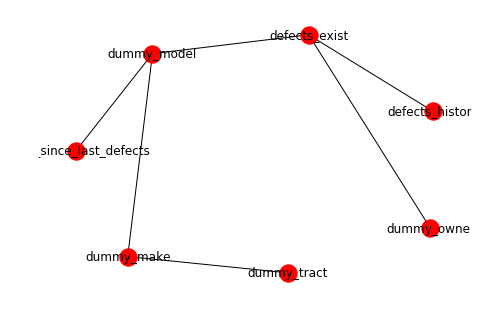

In [95]:
nx.draw(bn_raw_smote_3.to_undirected(), with_labels=True)
plt.show()